# 为训练过程添加额外的功能和优化

In [3]:
from importlib.metadata import version
import torch

print("torch version:", version("torch"))

torch version: 2.6.0


In [4]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "appendix-D", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

/Users/young/project/llmProject/LLMs-from-scratch-CN/appendix-D/01_main-chapter-code


In [5]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


In [6]:
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 词汇表大小
    "context_length": 256, # 缩短的上下文长度 （原始长度:1024）
    "emb_dim": 768,        # 嵌入维度
    "n_heads": 12,         # 注意力头的数量
    "n_layers": 12,        # 层数
    "drop_rate": 0.1,      # Dropout 比率
    "qkv_bias": False      # 查询-键-值偏置
}

torch.manual_seed(123)

# 初始化模型
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [7]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [8]:
from previous_chapters import create_dataloader_v1

# 划分训练集、验证集
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

## D.1 学习率预热

In [9]:
# 迭代epochs
n_epochs = 15
# 初始学习率
initial_lr = 0.0001
# 峰值学习率
peak_lr = 0.01

In [10]:
# 将预热步数的占比设置为20%
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

# 预热时的学习率增量
lr_increment = (peak_lr - initial_lr) / warmup_steps
print(lr_increment)


27
0.00036666666666666667


In [11]:
global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        # 学习率预热
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        
        # 更新学习率
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # 跟踪学习率
        track_lrs.append(optimizer.param_groups[0]["lr"])
        
        # 计算损失和更新权重
        # ...


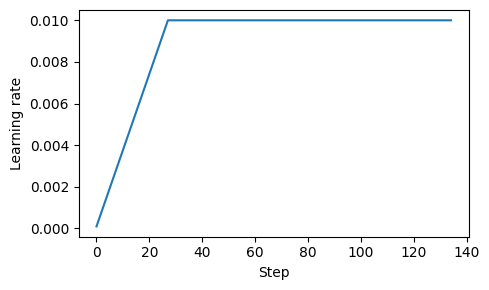

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout()
plt.savefig("1.pdf")
plt.show()

## D.2 余弦衰减

In [13]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        # 学习率调整
        if global_step < warmup_steps:
            # 预热
            lr = initial_lr + global_step * lr_increment
        else:
            # 预热结束后，开始余弦衰减
            progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
            # 将余弦函数沿y轴上移1, 并乘以0.5, 使范围在[0, 1]之间, 
            # 并乘以(peak_lr - min_lr), 使范围在[min_lr, peak_lr]之间
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        
        # 更新优化器
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

        # 计算损失和更新权重
        # ...

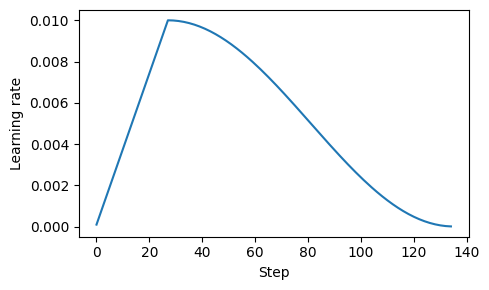

In [14]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout()
plt.savefig("2.pdf")
plt.show()

## D.3 梯度裁剪

In [15]:
from previous_chapters import calc_loss_batch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [16]:
# 找到最大梯度
def find_highest_gradient(model):
    max_grad = None
    l2_sum = 0
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            # 计算梯度范数
            l2_sum += torch.pow(grad_values, 2).sum()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad, torch.sqrt(l2_sum)

print(find_highest_gradient(model))

(tensor(0.0446, device='mps:0'), tensor(2.2223, device='mps:0'))


In [17]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

(tensor(0.0201, device='mps:0'), tensor(1.0000, device='mps:0'))


## D.4 修改的训练函数

In [21]:
from previous_chapters import evaluate_model, generate_and_print_sample

BOOK_VERSION = True

# 整合学习率预热、余弦衰减、梯度裁剪的训练函数
def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # 从优化器中获取最大学习率
    peak_lr = optimizer.param_groups[0]["lr"]

    # 计算训练过程中总的迭代次数
    total_training_steps = len(train_loader) * n_epochs

    # 计算预热阶段学习率的增量
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    # 使用新的策略进行训练
    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # 学习率预热和余弦衰减
            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment
            else:
                progress = ((global_step - warmup_steps) /
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # 更新优化器
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)

            # 反向传播
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # 梯度裁剪
            if BOOK_VERSION:
                if global_step > warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            else:
                if global_step >= warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # 参数更新
            optimizer.step()
            tokens_seen += input_batch.numel()

            # 模型评估
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # 打印损失
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
        
        # 模型输出测试
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs


In [22]:
import tiktoken
import time

start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps,
    initial_lr=1e-5, min_lr=1e-5
)

end_time = time.time()
execution_time_mins = (end_time - start_time) / 60
print(f"Execution time: {execution_time_mins:.2f} minutes")

Ep 1 (Iter 000000): Train loss 10.969, Val loss 10.938
Ep 1 (Iter 000005): Train loss 9.337, Val loss 9.460
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.823, Val loss 8.186
Ep 2 (Iter 000015): Train loss 6.343, Val loss 6.890
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.083, Val loss 6.594
Ep 3 (Iter 000025): Train loss 5.677, Val loss 6.786
Every effort moves you, the of the of the of the of the, the of the of the, the, the, the, the, the of the, the, the, the, the, the, the, the, the, the, the, the
Ep 4 (Iter 000030): Train loss 5.797, Val loss 6.841
Ep 4 (Iter 000035): Train loss 5.867, Val loss 6.880
Every effort moves you a a G                                               
Ep 5 (Iter 000040): Train loss 5.383, Val loss 6.653
Every effort moves you.            ", and the, and I had the, and I had the, and the, and I had the, and the the, and the, and the, and I

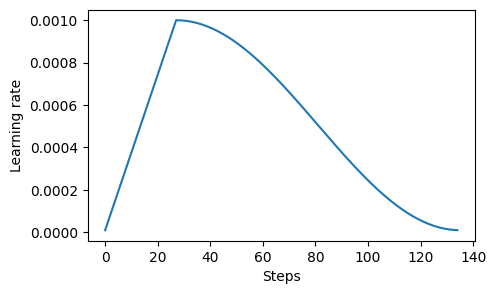

In [23]:
# 查看学习率的变化曲线
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

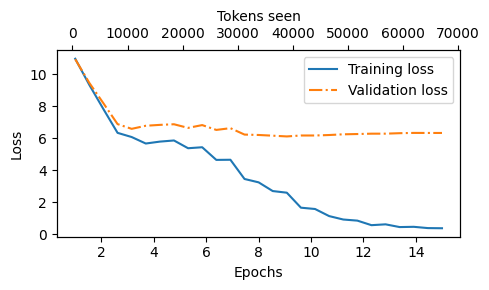

In [24]:
# 查看Loss的变化曲线
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout()
plt.savefig("3.pdf")
plt.show()